# World Wide Products Inc.

For the layman, a data scientist must seem like a psychic. They are able to analyze data and predict the future, just by looking at the past. And funny enough, they're not actually wrong. In this project, we will take on the roll of fortune teller, and attempt to predict the future order demand of a variety of products using **time series** and regression models.

## Retrieving the Data
This data comes from the [Forecasts for Product Demand dataset on Kaggle](https://www.kaggle.com/felixzhao/productdemandforecasting). We will begin by loading the dataset into a dataframe:

In [1]:
from os import path
import numpy as np
import pandas as pd

product_demand_df = pd.read_csv("data/raw/Historical Product Demand.csv")
product_demand_df.head()

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0993,Whse_J,Category_028,2012/7/27,100
1,Product_0979,Whse_J,Category_028,2012/1/19,500
2,Product_0979,Whse_J,Category_028,2012/2/3,500
3,Product_0979,Whse_J,Category_028,2012/2/9,500
4,Product_0979,Whse_J,Category_028,2012/3/2,500


Let's run through some quick information about this dataset:

In [2]:
product_demand_df.shape

(1048575, 5)

In [3]:
product_demand_df.keys()

Index(['Product_Code', 'Warehouse', 'Product_Category', 'Date',
       'Order_Demand'],
      dtype='object')

In order to effectively use this dataset, let's analyze the columns:

|Key              |Description|
|:----------------|:----------|
|Product_Code     |Product name, encoded|
|Warehouse        |Warehouse name, encoded|
|Product_Category |Category for each product, encoded|
|Date             |Date customer needs the product|
|Order_Demand     |Single order quantity|

## Cleaning Up the Data
There are some very simple things we can do to start cleaning the data. First, let's make the columns lowercase, just for consistency sake:

In [4]:
product_demand_df.columns = map(str.lower, product_demand_df.columns)
product_demand_df.keys()

Index(['product_code', 'warehouse', 'product_category', 'date',
       'order_demand'],
      dtype='object')

Let's check for any missing values:

In [5]:
product_demand_df[product_demand_df.isna().any(axis=1)].head()

,product_code,warehouse,product_category,date,order_demand
45460,Product_1461,Whse_A,Category_019,NaN,10000
456373,Product_1636,Whse_A,Category_019,NaN,100
456374,Product_1461,Whse_A,Category_019,NaN,300
456375,Product_1464,Whse_A,Category_019,NaN,300
456376,Product_1388,Whse_A,Category_019,NaN,200


It looks like we have a bunch of missing dates. Because we are doing time series forecasting, we require a date. Let's go ahead and drop all of these data points, as they are unusable to us.

In [6]:
indices_to_drop = product_demand_df[product_demand_df.isna().any(axis=1)].index
product_demand_df.drop(indices_to_drop, inplace=True)

Next, let's convert all of the information in `product_code`, `warehouse`, and `product_category` to integers:

In [7]:
unique_products = product_demand_df["product_code"].unique()
product_ordinal = {v: k for k, v in dict(enumerate(unique_products.flatten(), 1)).items()}
product_demand_df["product_code_ordinal"] = product_demand_df["product_code"].apply(lambda p: product_ordinal[p])

unique_warehouses = product_demand_df["warehouse"].unique()
warehouse_ordinal = {v: k for k, v in dict(enumerate(unique_warehouses.flatten(), 1)).items()}
product_demand_df["warehouse_ordinal"] = product_demand_df["warehouse"].apply(lambda w: warehouse_ordinal[w])

unique_categories = product_demand_df["product_category"].unique()
category_ordinal = {v: k for k, v in dict(enumerate(unique_categories.flatten(), 1)).items()}
product_demand_df["product_category_ordinal"] = product_demand_df["product_category"].apply(lambda c: category_ordinal[c])

product_demand_df.head()

,product_code,warehouse,product_category,date,order_demand,product_code_ordinal,warehouse_ordinal,product_category_ordinal
0,Product_0993,Whse_J,Category_028,2012/7/27,100,1,1,1
1,Product_0979,Whse_J,Category_028,2012/1/19,500,2,1,1
2,Product_0979,Whse_J,Category_028,2012/2/3,500,2,1,1
3,Product_0979,Whse_J,Category_028,2012/2/9,500,2,1,1
4,Product_0979,Whse_J,Category_028,2012/3/2,500,2,1,1


We also have an issue with our `order_demand` values. They are stored as strings, and almost all have something wrong with them:

In [8]:
# Prints all demands that are not numeric strings
product_demand_df["order_demand"][~product_demand_df["order_demand"].str.isnumeric()].shape

(1037336,)

**1037336** of our order demand values are in string form, rather than integers! Let's change that:

In [9]:
import re

# Extract all integers and save them
product_demand_df["order_demand"] = product_demand_df["order_demand"].apply(lambda x: int(re.findall(r"\d+", x)[0]))

Finally, let's convert all dates to `datetime` objects. From taking a look at the `date` values in a previous statement, it looks like the pattern is "_year/month/day_":

In [10]:
product_demand_df["date"] = pd.to_datetime(product_demand_df["date"], format="%Y/%m/%d")
product_demand_df["date"].describe()

count                 1037336
unique                   1729
top       2013-09-27 00:00:00
freq                     2075
first     2011-01-08 00:00:00
last      2017-01-09 00:00:00
Name: date, dtype: object

## Feature Engineering
To predict the demad of a specific product, we should make some new features that make that job easier. To do this, let's organize things by `product`, and create a new feature that specifies the `demand_per_month`

To start, let's split the date into a `months_since_start` integer to make `demand_per_month` calculations easier. We'll also do the `days_since_start` to test accuracy:

In [11]:
# Check if we have already processed the data:
if not path.exists("data/processed/product_demand_cleaned.csv"):
    
    # Get start date
    date_start = product_demand_df["date"].min()

    # Calculate days since start
    product_demand_df["days_since_start"] = product_demand_df["date"].apply(lambda date: (date - date_start).days)

    # Calculate months since start
    product_demand_df["months_since_start"] = product_demand_df["date"]\
        .apply(lambda date: ((date.year - date_start.year) * 12) + (date.month - date_start.month))

    # We don't need this date column anymore
    product_demand_df.drop(columns=["date"], inplace=True)

    # Save the cleaned data to a csv file
    product_demand_df.to_csv("data/processed/product_demand_cleaned.csv")
else:
    product_demand_df = pd.read_csv("data/processed/product_demand_cleaned.csv")
    product_demand_df.drop(product_demand_df.columns[0], axis=1, inplace=True) # Get rid of index column

product_demand_df.head()

,product_code,warehouse,product_category,order_demand,product_code_ordinal,warehouse_ordinal,product_category_ordinal,days_since_start,months_since_start
0,Product_0993,Whse_J,Category_028,100,1,1,1,566,18
1,Product_0979,Whse_J,Category_028,500,2,1,1,376,12
2,Product_0979,Whse_J,Category_028,500,2,1,1,391,13
3,Product_0979,Whse_J,Category_028,500,2,1,1,397,13
4,Product_0979,Whse_J,Category_028,500,2,1,1,419,14


Before we do the per month calculations, let's check the standard deviation of each product. This will help us later on down the line:

In [12]:
standard_deviations = product_demand_df.groupby("product_code")["order_demand"].std().reset_index()\
    .rename(columns={"order_demand": "product_standard_dev_day"})
standard_deviations = standard_deviations.replace(np.NaN, 0) # Make sure we have no NaN values
product_demand_df = pd.merge(product_demand_df , standard_deviations, on=["product_code"])
product_demand_df.head()

,product_code,warehouse,product_category,order_demand,product_code_ordinal,warehouse_ordinal,product_category_ordinal,days_since_start,months_since_start,product_standard_dev_day
0,Product_0993,Whse_J,Category_028,100,1,1,1,566,18,497.474763
1,Product_0993,Whse_J,Category_028,300,1,1,1,614,20,497.474763
2,Product_0993,Whse_J,Category_028,500,1,1,1,620,20,497.474763
3,Product_0993,Whse_J,Category_028,300,1,1,1,640,21,497.474763
4,Product_0993,Whse_J,Category_028,200,1,1,1,670,22,497.474763


Now let's do the per month calculations:

In [13]:
demand_products_month_df = product_demand_df[["product_code_ordinal", "months_since_start", "order_demand"]]\
    .groupby(["months_since_start", "product_code_ordinal"])["order_demand"].sum().reset_index()
# Add standard deviation feature
standard_deviations = demand_products_month_df.groupby("product_code_ordinal")["order_demand"].std().reset_index()\
    .rename(columns={"order_demand": "product_standard_dev_month"})
standard_deviations = standard_deviations.replace(np.NaN, 0) # Make sure we have no NaN values
demand_products_month_df = pd.merge(demand_products_month_df , standard_deviations, on=["product_code_ordinal"])
demand_products_month_df.head()

,months_since_start,product_code_ordinal,order_demand,product_standard_dev_month
0,0,45,2,7.681404
1,10,45,11,7.681404
2,11,45,1,7.681404
3,12,45,17,7.681404
4,13,45,29,7.681404


## Analysis
Let's start analyzing some data. Let's start by visualizing the purchases:

In [14]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

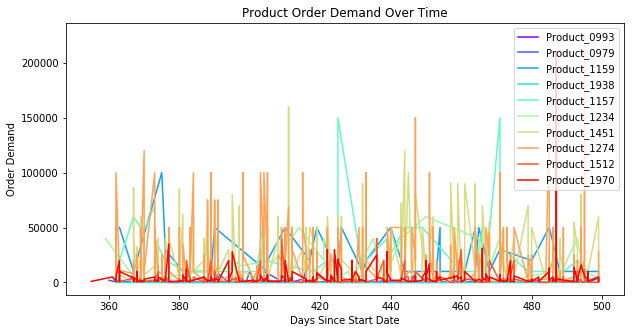

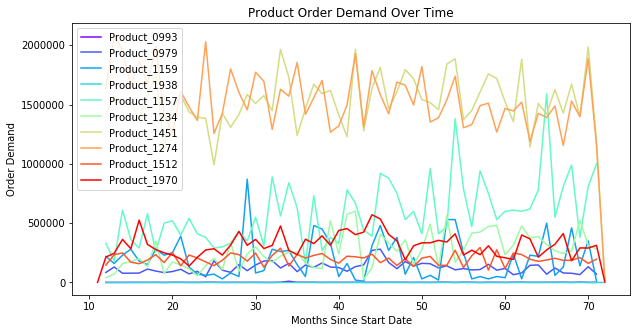

In [15]:
# Plot the daily data
plt.figure(figsize=(10, 5))

num_products_shown = 10
days_shown = 500 # There are too many days to show, so only take a subset of them

# Get data
data = product_demand_df.sort_values(by="days_since_start").loc[product_demand_df["days_since_start"] < days_shown]\
    .groupby(["product_code_ordinal"]).apply(lambda row: np.array(list(zip(row["days_since_start"], row["order_demand"]))))
data = np.array(list(data[:num_products_shown]))

# Define the color for each product
colors = cm.rainbow(np.linspace(0, 1, num_products_shown))
i = 0
# Plot all products
for d in data:
    plt.plot(d[:, 0], d[:, 1], color=colors[i], label=unique_products[i])
    i += 1
plt.title("Product Order Demand Over Time")
plt.xlabel("Days Since Start Date")
plt.ylabel("Order Demand")
plt.legend()

# Plot the monthly data
plt.figure(figsize=(10, 5))

# Get the data
data = demand_products_month_df.groupby(["product_code_ordinal"])\
    .apply(lambda row: np.array(list(zip(row["months_since_start"], row["order_demand"]))))
data = np.array(list(data[:num_products_shown]))

i = 0
# Plot all products
for d in data:
    plt.plot(d[:, 0], d[:, 1], color=colors[i], label=unique_products[i])
    i += 1
plt.title("Product Order Demand Over Time")
plt.xlabel("Months Since Start Date")
plt.ylabel("Order Demand")
plt.legend()

plt.show()

Oh boy, that's a lot of colors. Let's pick one product that ideally has a large number of data points but a low standard deviation - this will lead to the most accurate predictions:

In [16]:
# Find the products with the most data points
products_with_most_data = product_demand_df.groupby("product_code_ordinal").size()\
    .sort_values(ascending=False)[:100].reset_index()["product_code_ordinal"].values

# Find a subset of the above products with the lowest standard deviation over days
products_with_low_std = product_demand_df.loc[product_demand_df["product_code_ordinal"].isin(products_with_most_data)]\
    .groupby("product_code_ordinal").first()["product_standard_dev_day"]\
    .sort_values(ascending=True).reset_index()["product_code_ordinal"].values

# Only pick 5 of them
num_viable_products = 5
viable_product_ordinals = products_with_low_std[:num_viable_products]
viable_products = product_demand_df.loc[product_demand_df["product_code_ordinal"].isin(viable_product_ordinals)]\
    .reset_index().sort_values(by="days_since_start")
viable_product_codes = viable_products.groupby("product_code_ordinal").first()["product_code"]

viable_products[["product_code", "product_code_ordinal", "product_standard_dev_day"]]\
    .groupby("product_code_ordinal").first().sort_values(by="product_standard_dev_day").head().reset_index()

,product_code_ordinal,product_code,product_standard_dev_day
0,81,Product_0613,10.577811
1,153,Product_0608,17.175626
2,151,Product_0620,21.093205
3,1377,Product_0361,23.662398
4,342,Product_0495,31.023758


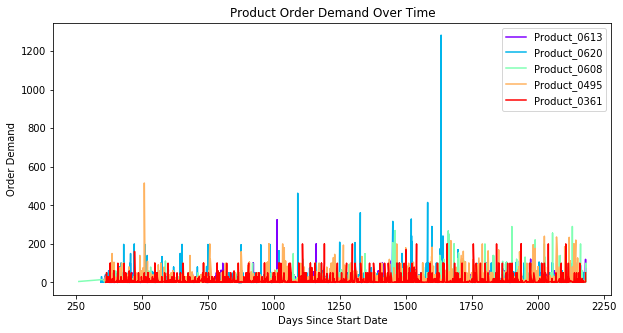

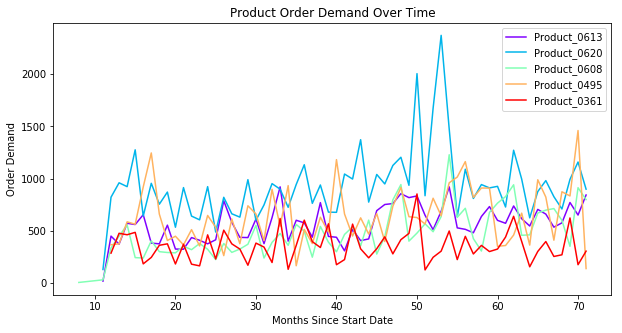

In [17]:
# Plot the daily data
plt.figure(figsize=(10, 5))

data = viable_products.groupby(["product_code_ordinal"])\
    .apply(lambda row: np.array(list(zip(row["days_since_start"], row["order_demand"], row["product_code_ordinal"]))))
data = np.array(list(data))

colors = cm.rainbow(np.linspace(0, 1, len(data)))
for i, d in enumerate(data):
    ordinal = d[0, 2]
    plt.plot(d[:, 0], d[:, 1], color=colors[i], label=viable_product_codes[ordinal])
plt.title("Product Order Demand Over Time")
plt.xlabel("Days Since Start Date")
plt.ylabel("Order Demand")
plt.legend()

# Plot the monthly data
plt.figure(figsize=(10, 5))

viable_products_month = demand_products_month_df\
    .loc[demand_products_month_df["product_code_ordinal"].isin(viable_product_ordinals)].reset_index()
data = viable_products_month.groupby(["product_code_ordinal"])\
    .apply(lambda row: np.array(list(zip(row["months_since_start"], row["order_demand"], row["product_code_ordinal"]))))
data = np.array(list(data))

for i, d in enumerate(data):
    ordinal = d[0, 2]
    plt.plot(d[:, 0], d[:, 1], color=colors[i], label=viable_product_codes[ordinal])
plt.title("Product Order Demand Over Time")
plt.xlabel("Months Since Start Date")
plt.ylabel("Order Demand")
plt.legend()

plt.show()

That's much more readable! Let's do some predictions!

## Predicting Order Demand Using Daily Values
To do this, we will use a method called `10-fold Cross-Validation`. In this, we will use 90% of the test data as training data and the remaining 10% as test data. Then, we will fit the model again by shifting both the training data and test data by 10%, so we are training and testing over a different dataset. We will do this 10 times to get through all of the data (hence, 10-fold)

Because we are using time series, we will tweak this just a bit. Instead of training using the remaining 90% every time, we will instead increment the amount of training data, starting with 10%, then 20%, then 30%,... This way, we do not have to use future data that we have not seen yet. We will also only go to 80%, as after testing this proved to be more accurate.

In [19]:
import math
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

#### Gradient Boosting

In [20]:
grad_boost = GradientBoostingRegressor()

# Define how large the folds should be
ten_fold_step_size = math.floor(0.10 * viable_products.shape[0])
# 10-fold cross-validation
training_length = ten_fold_step_size
while training_length < 8 * ten_fold_step_size:
    training_data = viable_products.loc[range(training_length)]
    training_data_l = training_data["order_demand"]
    training_data_f = training_data[["product_code_ordinal", "warehouse_ordinal", "product_category_ordinal", "days_since_start"]]
    grad_boost.fit(training_data_f, training_data_l)
    training_length += ten_fold_step_size

# Predict the testing data
testing_data = viable_products.loc[range(8 * ten_fold_step_size, 10 * ten_fold_step_size)]
testing_data_l = testing_data["order_demand"].values
testing_data_f = testing_data[["product_code_ordinal", "warehouse_ordinal", "product_category_ordinal", "days_since_start"]]
prediction = grad_boost.predict(testing_data_f)
grad_boost_accuracy = r2_score(prediction, testing_data_l)
print("Gradient Boost r2 Score (with daily values): {}".format(grad_boost_accuracy))

Gradient Boost r2 Score (with daily values): -1.2751981222388622


Well, that's not awful, but it's not great either. Let's go ahead and see how it looks plotted:

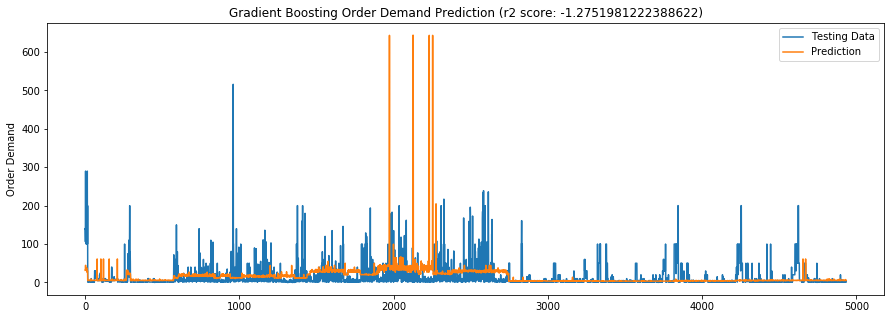

In [21]:
plt.figure(figsize=(15,5))
plt.plot(testing_data_l, label="Testing Data")
plt.plot(prediction, label="Prediction")
plt.title("Gradient Boosting Order Demand Prediction (r2 score: {})".format(grad_boost_accuracy))
plt.ylabel("Order Demand")
plt.legend()
plt.show()

Hm, not super great. It looks like it's just assuming that the order demand will be zero, and that's why it is fairly effective. Let's try it with the monthly data:

In [22]:
viable_products_month.head()

,index,months_since_start,product_code_ordinal,order_demand,product_standard_dev_month
0,184,8,153,5,225.754916
1,185,11,153,30,225.754916
2,186,12,153,336,225.754916
3,187,13,153,449,225.754916
4,188,14,153,557,225.754916


In [23]:
grad_boost = GradientBoostingRegressor()

ten_fold_step_size = math.floor(0.10 * viable_products_month.shape[0])
# 10-fold cross-validation
training_length = ten_fold_step_size
while training_length < 8 * ten_fold_step_size:
    training_data = viable_products_month.loc[range(training_length)]
    training_data_l = training_data["order_demand"]
    training_data_f = training_data[["product_code_ordinal", "months_since_start"]]
    grad_boost.fit(training_data_f, training_data_l)
    training_length += ten_fold_step_size

testing_data = viable_products_month.loc[range(8 * ten_fold_step_size, 10 * ten_fold_step_size)]
testing_data_l = testing_data["order_demand"].values
testing_data_f = testing_data[["product_code_ordinal", "months_since_start"]]
prediction = grad_boost.predict(testing_data_f)
grad_boost_accuracy = r2_score(prediction, testing_data_l)
print("Gradient Boost r2 Score (with daily values): {}".format(grad_boost_accuracy))

Gradient Boost r2 Score (with daily values): -4.785277740025599


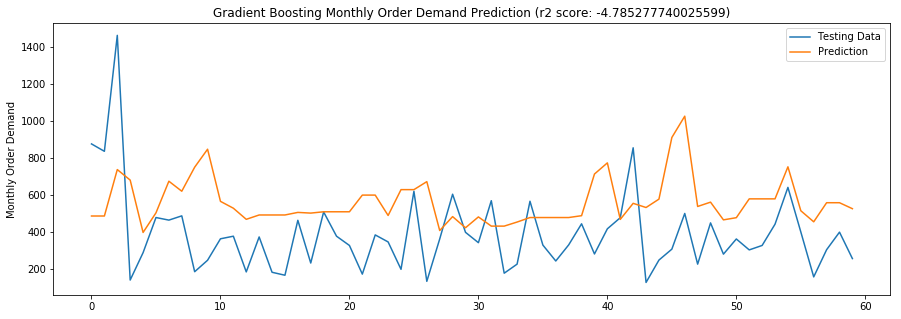

In [24]:
plt.figure(figsize=(15,5))
plt.plot(testing_data_l, label="Testing Data")
plt.plot(prediction, label="Prediction")
plt.title("Gradient Boosting Monthly Order Demand Prediction (r2 score: {})".format(grad_boost_accuracy))
plt.ylabel("Monthly Order Demand")
plt.legend()
plt.show()

Wow, that's much worse! I believe the issue here is just that we don't have enough data to train over and because of a mixture of that and how erratic the order demand actually is, our monthly order score is very poor. Let's try one last thing before we end:

#### Linear Regression
Okay, this may be cheating a bit. But considering that a majority of the order demands are the same value (or 0), a linear regression model may be able to predict the future order demand better than other models:

In [25]:
linear_reg = LinearRegression()

ten_fold_step_size = math.floor(0.10 * viable_products.shape[0])
# 10-fold cross-validation
training_length = ten_fold_step_size
while training_length < 8 * ten_fold_step_size: # Go up to 80%, as that is more accurate
    training_data = viable_products.loc[range(training_length)]
    training_data_l = training_data["order_demand"]
    training_data_f = training_data[["product_code_ordinal", "warehouse_ordinal",
                                     "product_category_ordinal", "months_since_start"]]
    linear_reg.fit(training_data_f, training_data_l)
    training_length += ten_fold_step_size

testing_data = viable_products.loc[range(8 * ten_fold_step_size, 10 * ten_fold_step_size)]
testing_data_l = testing_data["order_demand"].values
testing_data_f = testing_data[["product_code_ordinal", "warehouse_ordinal",
                               "product_category_ordinal", "months_since_start"]]
prediction = linear_reg.predict(testing_data_f)
linear_reg_accuracy = r2_score(prediction, testing_data_l)
print("Linear Regression r2 Score (with daily values): {}".format(linear_reg_accuracy))

Linear Regression r2 Score (with daily values): -13.97571052690203


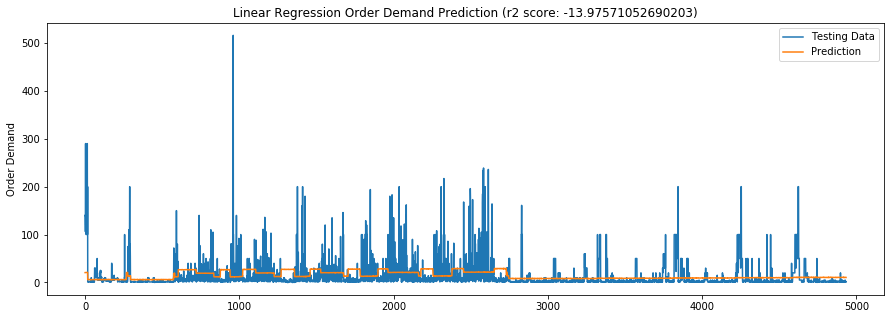

In [26]:
plt.figure(figsize=(15,5))
plt.plot(testing_data_l, label="Testing Data")
plt.plot(prediction, label="Prediction")
plt.title("Linear Regression Order Demand Prediction (r2 score: {})".format(linear_reg_accuracy))
plt.ylabel("Order Demand")
plt.legend()
plt.show()

Interesting, this ended up being much worse than our **Gradient Boosting** model! It looks like the reason is that the order demand does fluctuate a lot more than initially expected, leading to a very non-linear variance. Although I have a feeling I know what to expect, let's try this on the monthly data:

In [27]:
linear_reg = LinearRegression()

ten_fold_step_size = math.floor(0.10 * viable_products_month.shape[0])
# 10-fold cross-validation
training_length = ten_fold_step_size
while training_length < 8 * ten_fold_step_size:
    training_data = viable_products_month.loc[range(training_length)]
    training_data_l = training_data["order_demand"]
    training_data_f = training_data[["product_code_ordinal", "months_since_start"]]
    linear_reg.fit(training_data_f, training_data_l)
    training_length += ten_fold_step_size

testing_data = viable_products_month.loc[range(8 * ten_fold_step_size, 10 * ten_fold_step_size)]
testing_data_l = testing_data["order_demand"].values
testing_data_f = testing_data[["product_code_ordinal", "months_since_start"]]
prediction = linear_reg.predict(testing_data_f)
linear_reg_accuracy = r2_score(prediction, testing_data_l)
print("Linear Regression r2 Score (with daily values): {}".format(linear_reg_accuracy))

Linear Regression r2 Score (with daily values): -40.62154582349825


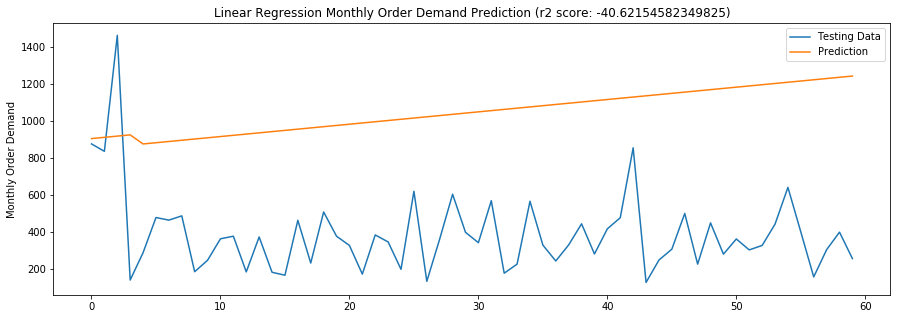

In [28]:
plt.figure(figsize=(15,5))
plt.plot(testing_data_l, label="Testing Data")
plt.plot(prediction, label="Prediction")
plt.title("Linear Regression Monthly Order Demand Prediction (r2 score: {})".format(linear_reg_accuracy))
plt.ylabel("Monthly Order Demand")
plt.legend()
plt.show()

Yep, precisely what I expected. Due to the erratic nature of the monthly data, a linear model is a bad choice for predicting this data.

## Conclusion
Ultimately, we were unable to accurately predict the order demand of the products. What happened? Well, our best model was the **Gradient Boosting** model on daily data focusing on products that have a _low standard deviation_ and a high _number of data points_. Unfortunately, using this model, even with 10-fold cross-verification, we still only ended up with an r2 score of around `-1.5`, which is not stellar. The **Gradient Boosting** model with monthly data was surprisingly worse, which was the opposite of my hypothesis. I believe the error here came from too few data points leading to an innacurate prediction. Also, the aggregation of data into monthly buckets caused the data to become more erratic, leading to more inaccuracy. I ended with trying a **Linear Regression** model, attempting to "cheat" the system and just predict the average order demand. This is precisely what it ended up doing, but this was a lot more inaccurate than initially predicted, as it turns out the data was much more erratic than initially suspected. I also performed this on the monthly data... It did not end well.